In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import glob
import sys
from tqdm.notebook import tqdm
from utils import visualize_many_images

먼저, 수집한 사진 데이터를 visualize 해보았다. matplotlib를 활용하면 금방 구현할 수 있다. 주로 사람의 얼굴이 포함된 증명사진이 잘 모였지만, 얼굴이 너무 작거나, 너무 여러 사람이거나, 아예 없는 경우도 존재하기 때문에 이를 구분해주려고 한다.

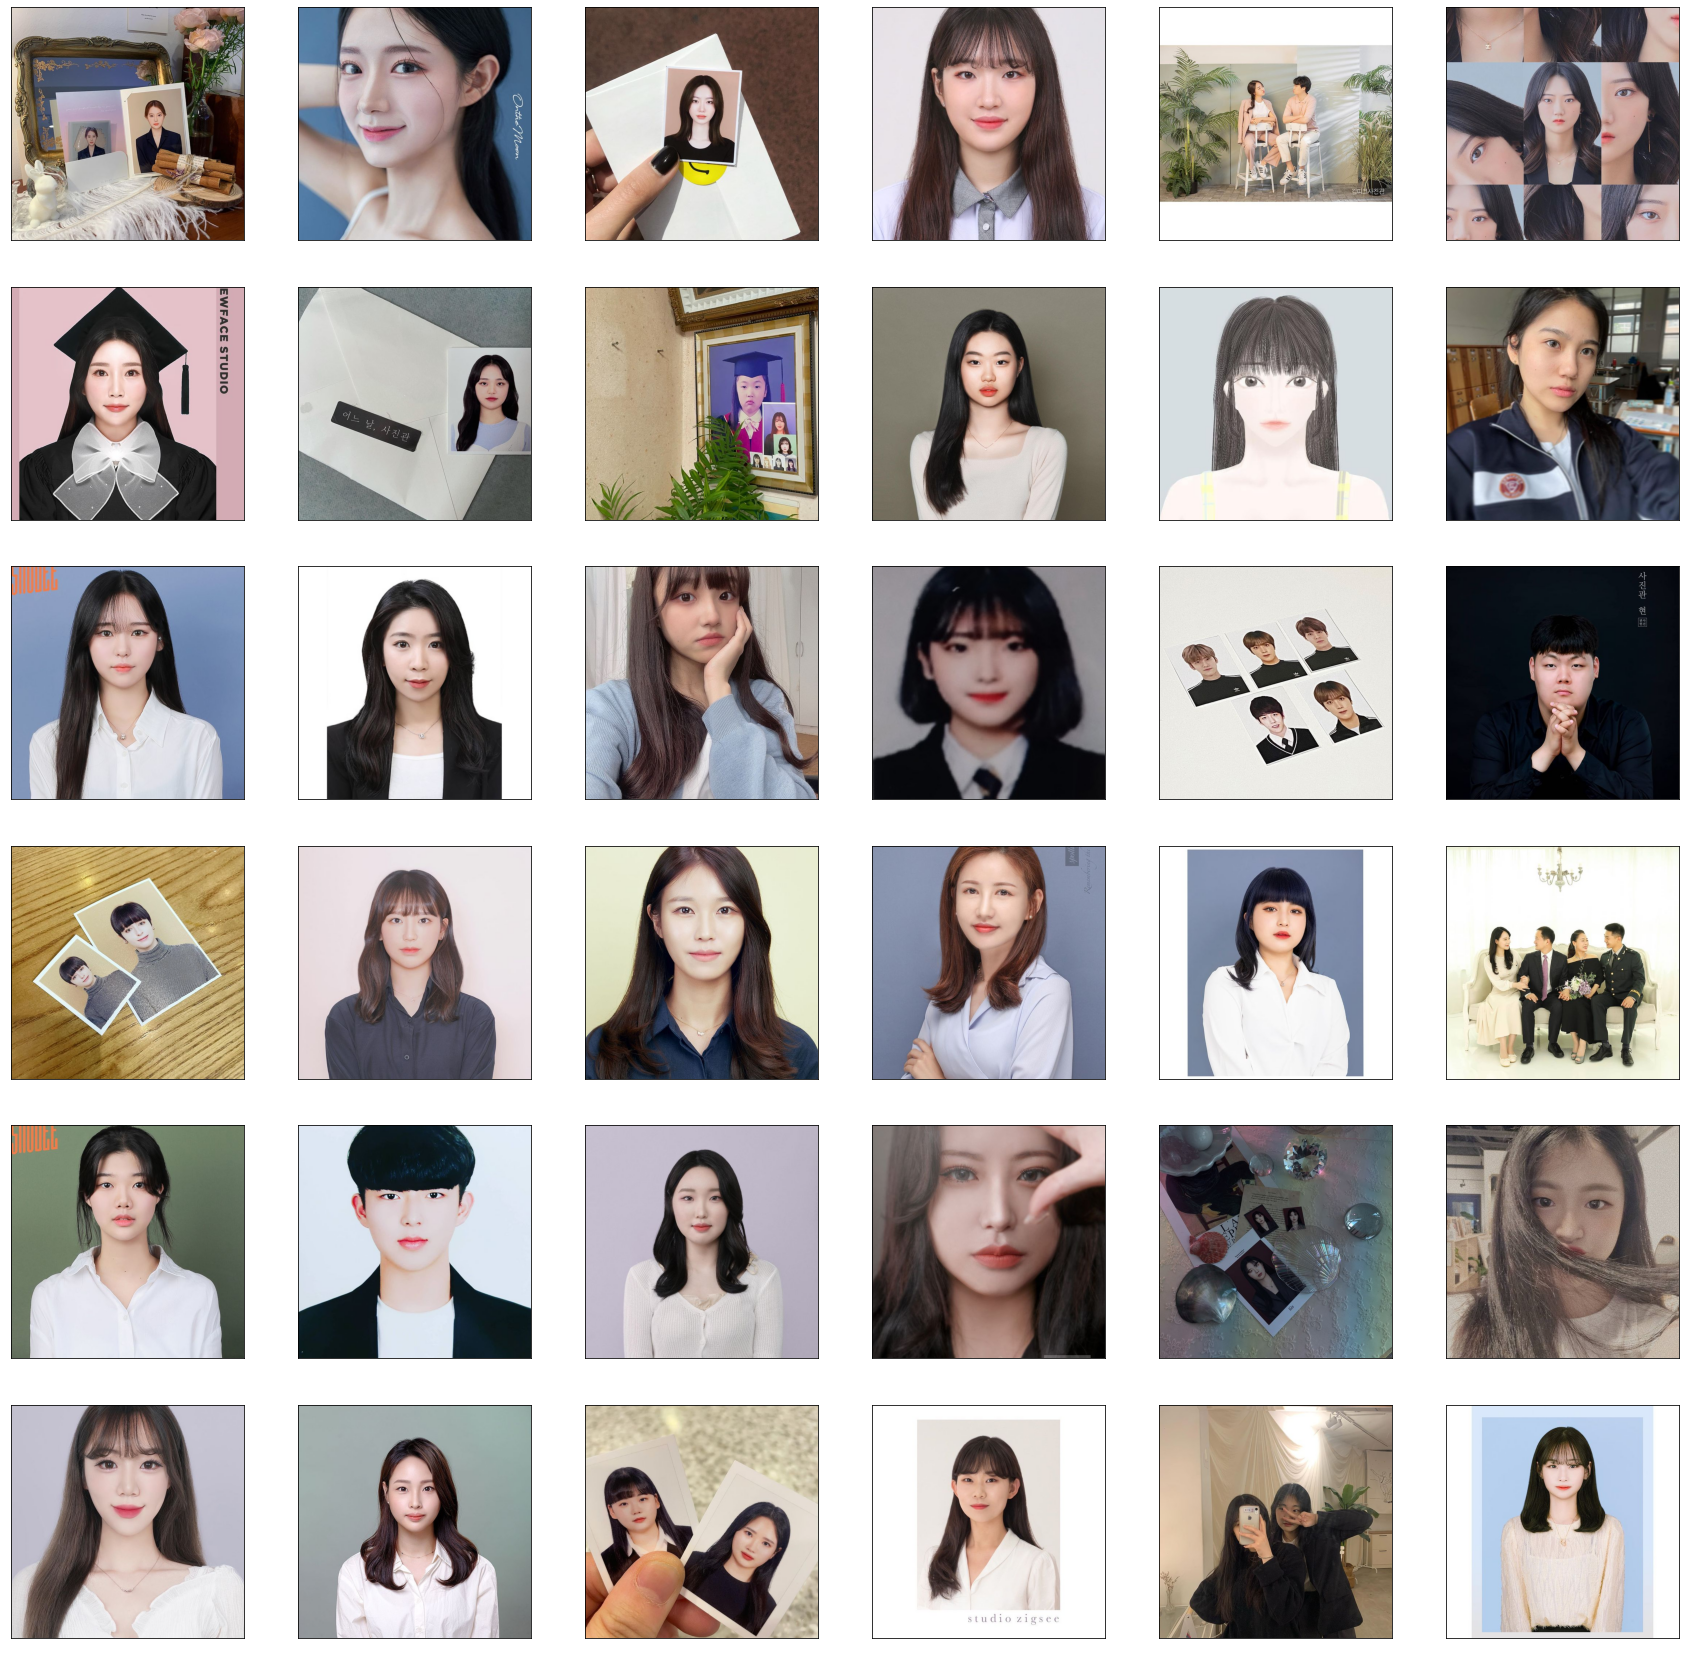

In [2]:
visualize_many_images(glob.glob("./img/*.jpg"))

### 사람 얼굴이 맞는지 검증

사람 얼굴이 없거나 너무 많은 사진의 경우에는 데이터에서 제외하기 위함이다. opencv를 이용하여 간단하게 구현할 수 있다. (별도의 훈련 필요 없음)

[opencv pre-trained face recognition](https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81)

더불어, 특정 해상도가 넘는 사진들의 경우 얼굴을 중심으로 잘라 주어야 좋다. 나는 512x512 해상도의 사진들만 훈련에 이용할 것이므로, 해당 사이즈로 이미지를 잘라줘야 하는 작업이 필요하다. 그렇기 때문에, 얼굴의 중심부를 알아내고 이를 가운데로 하여 이미지를 잘라내기로 하였다. 

In [3]:
def find_faces(filepath, scaleFactor = 1.3):
    '''
    사람 얼굴을 자동으로 detect하여 해당하는 사각형의 위치 정보를 반환합니다. 
    리스트는 차례대로 사각형 왼쪽 아래의 (x,y) 좌표, 너비, 높이 로 이루어져 있습니다. 
    
    Args:
        filepath(str):
            얼굴을 탐색하고자 하는 사진의 경로. 
        scaleFactor(float):
            CascadeClassifier,detectMultiScale의 hyperparameter 중 하나
            default는 1.3
            
    Output:
        faces(list):
            [[x , y , width, height]]
            항상 2차원 리스트로 만들어져 return 됩니다. 
    '''
    cascPath = './face_recognition.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    image = cv2.imread(filepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=scaleFactor,
        minNeighbors=5,
        minSize=(30, 30),
    )
    num_faces = len(faces)
    return faces

In [4]:
def visualize_face(filepath, faces):
    '''
    감지한 얼굴을 시각화해주는 함수입니다. 
    
    Args:
        filepath(str):
            얼굴을 탐색하고자 하는 사진의 경로. 
        faces(list):
            find_faces()에서 구한 faces의 좌표 list
            2차원 list도 입력받아 여러 개의 얼굴을 표현할 수 있습니다. 
    '''
    plt.figure(figsize=(20,20))
    image = cv2.imread(filepath)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    for x, y, w, h in faces:
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='red', fill=False)
        ax.add_patch(rect)
    plt.show()

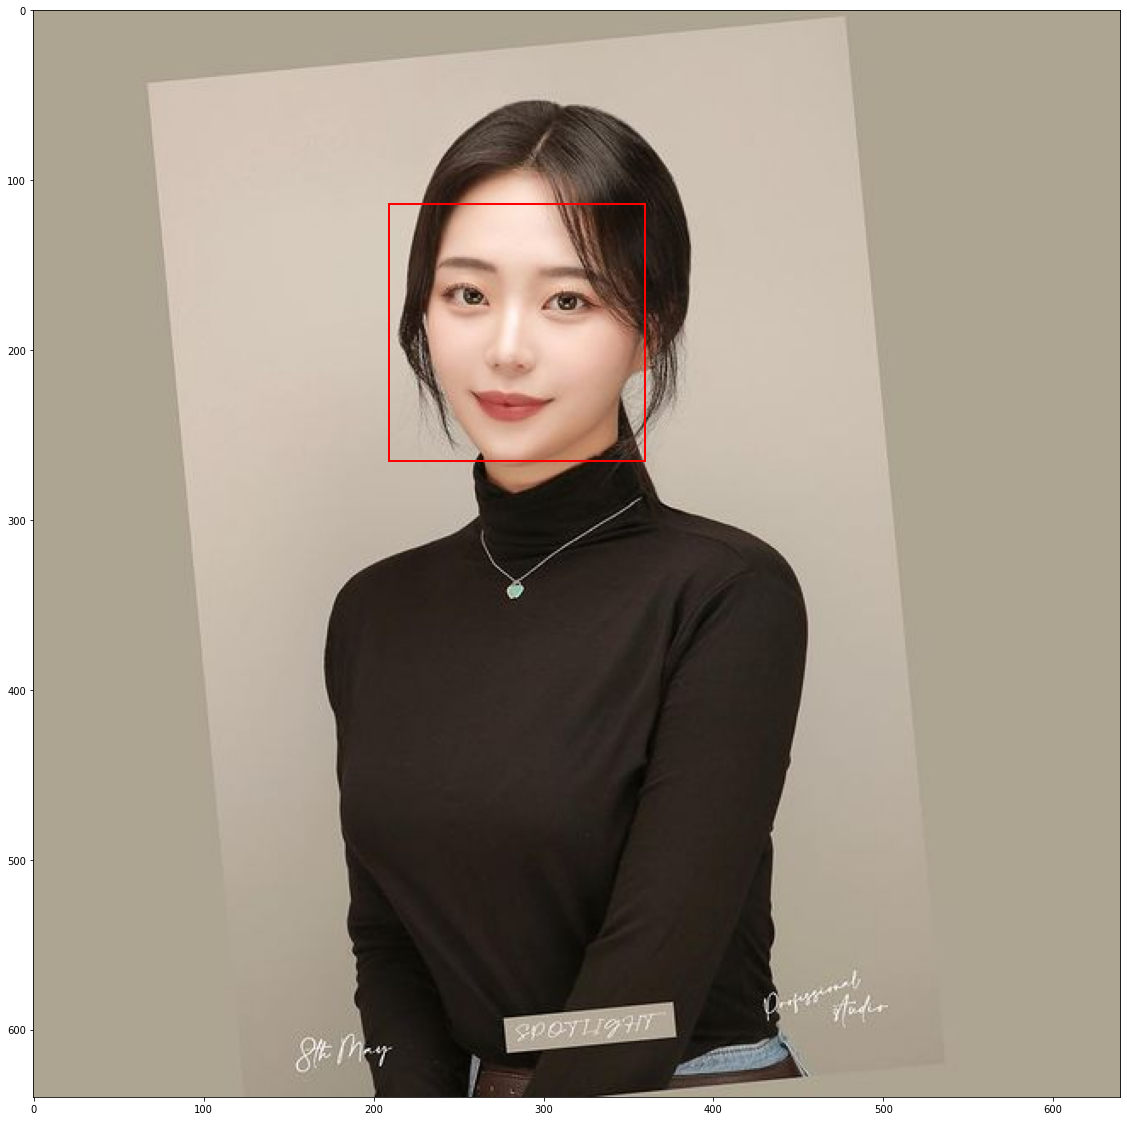

In [5]:
visualize_face('./img/id_photo443.jpg', find_faces('./img/id_photo443.jpg')) #사용예시

In [6]:
def cut_image(filename_list, width, heigth, filename_startpoint, cut_image_list):
    '''
    이미지를 설정한 크기로 잘라서 저장합니다. 이 때, 얼굴을 감지하고 이를 통하여 얼굴이 존재하는 곳만 잘라줍니다. 
    1. 얼굴이 없거나 2개 이상으로 설정된 경우 => 이미지를 저장하지 않고 pass 합니다.
    2. 얼굴이 1개인데 설정한 크기보다 작은 경우 => 이미지를 설정한 값으로 더 키워서 저장합니다.
    3. 얼굴이 1개이고 설정한 크기보다 이미지가 큰 경우 => 얼굴의 중심을 전체 사진의 중심으로 잡고 저장합니다. 
    '''
    n = filename_startpoint
    for filename in tqdm(filename_list):
        image = cv2.imread(filename)
        faces = find_faces(filename)
        if len(faces) == 1:
            if image.shape[0] < width or image.shape[1] < heigth:
                cut_image = cv2.resize(image, dsize = (width, heigth), interpolation=cv2.INTER_AREA)
                cv2.imwrite('./cut_img/cut_img'+str(n)+'.jpg', cut_image)
                cut_image_list.append('./cut_img/cut_img'+str(n)+'.jpg')
                n+=1
                continue
            else:
                mid_point = ((faces[0][0]+(faces[0][2]//2)), (faces[0][1]+(faces[0][3]//2)))
                width_point = [mid_point[0]-width, mid_point[0]+width]
                heigth_point = [mid_point[1]-heigth, mid_point[1]+heigth]
                
                if width_point[0] < 0:
                    width_point = [0,width]
                elif width_point[1] > image.shape[0]:
                    width_point = [image.shape[0]-width, image.shape[0]]
                
                if heigth_point[0] < 0:
                    heigth_point = [0,heigth]
                elif heigth_point[1] > image.shape[1]:
                    heigth_point = [image.shape[1]-heigth, image.shape[1]]
                
                cut_image = image[width_point[0]:width_point[1], heigth_point[0]:heigth_point[1]].copy()
                cv2.imwrite('./cut_img/cut_img'+str(n)+'.jpg', cut_image)
                cut_image_list.append('./cut_img/cut_img'+str(n)+'.jpg')
                n+=1

In [19]:
cut_image_list = []
cut_image(glob.glob("./img/*.jpg"), 512,512,0, cut_image_list)

  0%|          | 0/469 [00:00<?, ?it/s]

In [21]:
len(cut_image_list) #469개의 크롤링한 사진들 중 315개가 남음

315

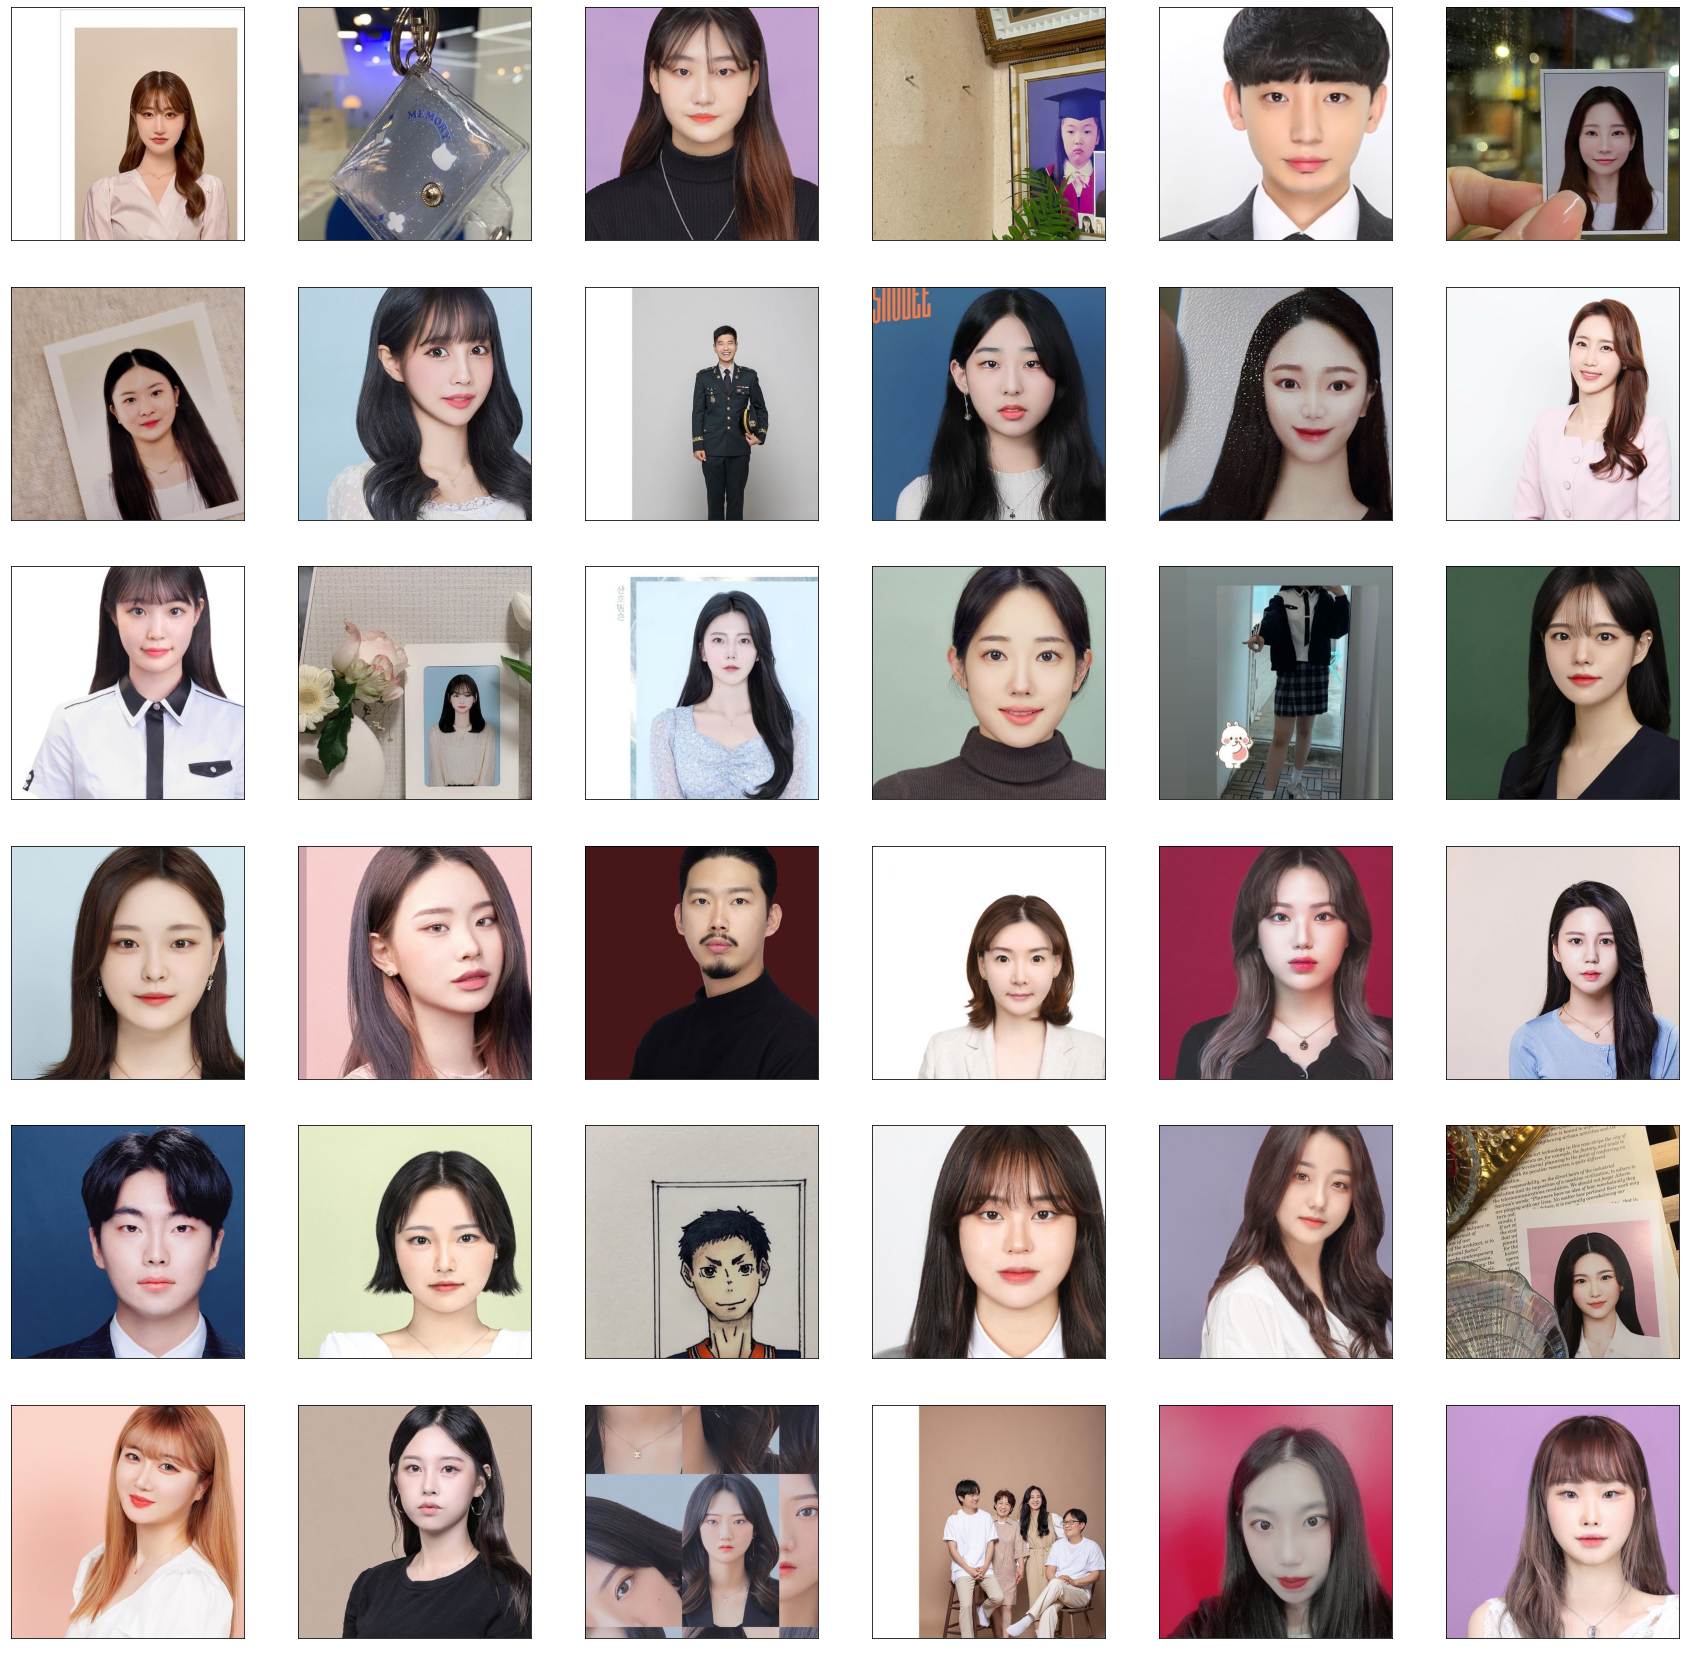

In [22]:
visualize_many_images(glob.glob("./cut_img/*.jpg"))

In [14]:
n=0
for i in glob.glob("./cut_img/*jpg"):
     n+=1
print(n)

315


In [15]:
cut_image_list = []
cut_image(glob.glob("./kaggle_img/Humans/*.jpg"), 512,512,n, cut_image_list)

  0%|          | 0/6973 [00:00<?, ?it/s]